In [216]:
from __future__ import print_function
from __future__ import division

from ast import literal_eval

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
import time
import h5py
import argparse
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd

import masked_networks
from tf_plus import learning_phase, batchnorm_learning_phase
from tf_plus import sess_run_dict, add_classification_losses
from tf_plus import summarize_weights
from train_supermask import make_parser, read_input_data, \
    init_model, load_initial_weights, split_and_shape

In [222]:
metaparser = argparse.ArgumentParser()
metaparser.add_argument('--experiment_name', type=str, required=True)
meta_args = metaparser.parse_args(["--experiment_name", "control_3"])

In [224]:
def build_input_dir(seed, meta_args):
    attempt_num = 0
    experiment_name = meta_args.experiment_name
    pretrained_epochs = None

    if experiment_name == "control_3":
        input_dir = "./results/iter_lot_fc_orig/learned_supermasks_seed_{seed}_attempt_{attempt_num}/run1".format(
            seed=seed,
            attempt_num=attempt_num)

    elif experiment_name == "pretrained_supermask":
        input_dir = "./results/iter_lot_fc_orig/fc_lot_${pretrained_epochs}_epochs_seed_${seed}_${attempt_num}/run1".format(
            pretrained_epochs=pretrained_epochs,
            seed=seed,
            attempt_num=attempt_num)
    return input_dir


parser = make_parser()
# Have a seed just to satisfy the requirements
seed = 1
input_dir = build_input_dir(seed, meta_args)

args_str = """--train_h5 ./data/mnist_train.h5 --test_h5 ./data/mnist_test.h5
--arch fc_mask --opt sgd --lr 100 --num_epochs 500 --print_every 220
--eval_every 220 --log_every 220 --save_weights --save_every 22000
--tf_seed {}
--init_weights_h5 {}
""".format(seed, input_dir).split()
args = parser.parse_args(args_str)

In [3]:
train_x, train_y = read_input_data(args.train_h5)
test_x, test_y = read_input_data(args.test_h5) # used as val for now
images_scale = np.max(train_x)
if images_scale > 1:
    print('Normalizing images by a factor of {}'.format(images_scale))
    train_x = train_x / images_scale
    test_x = test_x / images_scale


if args.test_batch_size == 0:
    args.test_batch_size = test_y.shape[0]

print('Data shapes:', train_x.shape, train_y.shape, test_x.shape, test_y.shape)
if train_y.shape[0] % args.train_batch_size != 0:
    print("WARNING batch size doesn't divide train set evenly")
if train_y.shape[0] % args.large_batch_size != 0:
    print("WARNING large batch size doesn't divide train set evenly")
if test_y.shape[0] % args.test_batch_size != 0:
    print("WARNING batch size doesn't divide test set evenly")

# build model, masked networks
if args.arch == 'fc_mask':
    model = masked_networks.build_fc_supermask(args)
else:
    raise Exception("Not prepared for non fc_mask model")
        
init_model(model, args)

sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

Normalizing images by a factor of 255
Data shapes: (55000, 28, 28, 1) (55000,) (10000, 28, 28, 1) (10000,)
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [215]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


def visualize_mask_weights(mask_layers, seed):
    num_bins = 20
    for i, mask_layer in enumerate(mask_layers):
        plt.subplot(len(mask_layers), 2, i * 2 + 1)
        plt.hist(mask_layer.flatten(), bins=num_bins)
        plt.xlabel("Raw mask values at layer {}".format(i))
        plt.subplot(len(mask_layers), 2, i * 2 + 2)
        plt.hist(sigmoid(mask_layer.flatten()), bins=num_bins)
        plt.xlabel("Sigmoided mask values at layer {}".format(i))
    plt.tight_layout()
    plt.savefig(os.path.join(args.init_weights_h5,
        "mask_dists_seed_{}.png".format(seed)))
    plt.show()
    
def get_test_accs(run_dir):
    test_accs = []
    for filename in os.listdir(run_dir):
        if 'tfevents' in filename:
            for e in tf.compat.v1.train.summary_iterator(os.path.join(
                run_dir, filename
            )):
                for v in e.summary.value:
                    if v.tag == 'eval_test_acc':
                        test_accs.append(v.simple_value)
    return np.array(test_accs)

In [225]:
def run_analysis_on_seed(seed, meta_args):
    seed_info = {
        "seed": seed,
        "regular_epochs": 0,
        "supermask_epochs": 500,
        "experiment_name": "control_3",
        "has_supermask": 1,
        "has_lth": 0,
        "test_accuracy": None
    }
    
    args.init_weights_h5 = build_input_dir(seed, meta_args)
    if not args.init_weights_h5.endswith('/weights'):
        h5file = os.path.join(args.init_weights_h5, 'weights')
    else:
        h5file = args.init_weights_h5
    hf_weights = h5py.File(h5file, 'r')
    all_weights = hf_weights.get('all_weights')
    print("Number of weight copies:", len(all_weights))
    init_weights_flat = all_weights[0]
    final_weights_flat = all_weights[-1]
    current_mask = np.array(hf_weights.get('mask_values'))

    shapes = [literal_eval(s) for s in hf_weights.attrs['var_shapes'].decode('utf-8').split(';')]
    hf_weights.close()

    weight_values = split_and_shape(init_weights_flat, shapes)
    final_weight_values = split_and_shape(final_weights_flat, shapes)
    gk = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES)
    if len(gk) > 9:
        print("You need to restart the kernel - graphkeys have been replicated" +
              " and there's no going back")

    for i, w in enumerate(gk):
       #if 'mask' not in w.name: # HACK for biased masks
        print('loading weights for layer {}: {}'.format(i, w.name))
        w.load(weight_values[i], session=sess)


    mask_layers = final_weight_values[2::3]
    print("Basic info")
    all_mask_weights = []
    for mask_layer in mask_layers:
        print("Shape:", mask_layer.shape)
        print("Average fraction masked:", 1-sigmoid(mask_layer).mean())
        print("Min: {}, Max: {}\n".format(
            mask_layer.min(), mask_layer.max()))
        all_mask_weights.append(mask_layer.flatten())
    all_mask_weights = np.concatenate(all_mask_weights)
    print("Total average fraction masked:", 1-sigmoid(all_mask_weights).mean())
    
    # Visualize and save img of mask weight distribution
    visualize_mask_weights(mask_layers, seed)
    
    seed_info["test_accuracy"] = get_test_accs(args.init_weights_h5).max()
    return seed_info

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.49366632629611207
Min: -8.745142936706543, Max: 8.770081520080566

Shape: (300, 100)
Average fraction masked: 0.4430654096143837
Min: -9.099223136901855, Max: 9.445528984069824

Shape: (100, 10)
Average fraction masked: 0.2941315581819023
Min: -11.061659812927246, Max: 11.945895195007324

Total average fraction masked: 0.48721417652689325


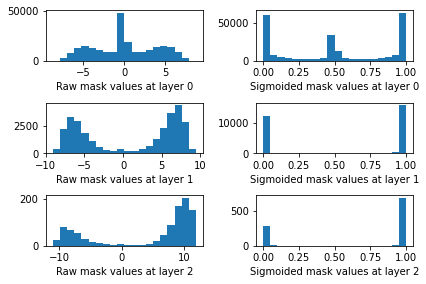

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.49401024543782923
Min: -8.639673233032227, Max: 8.84908390045166

Shape: (300, 100)
Average fraction masked: 0.44542809403215067
Min: -9.390898704528809, Max: 9.471814155578613

Shape: (100, 10)
Average fraction masked: 0.266864942915776
Min: -11.189888000488281, Max: 12.006192207336426

Total average fraction masked: 0.48768188388751965


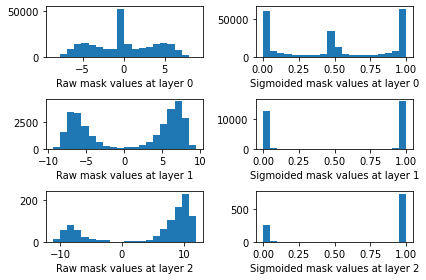

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.49527027007267577
Min: -8.856532096862793, Max: 8.800651550292969

Shape: (300, 100)
Average fraction masked: 0.4476040438964364
Min: -9.175764083862305, Max: 9.510625839233398

Shape: (100, 10)
Average fraction masked: 0.2679447130570237
Min: -10.46463680267334, Max: 11.938383102416992

Total average fraction masked: 0.48904445361023086


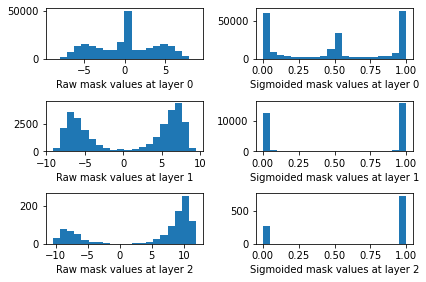

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.4936519118269175
Min: -8.797584533691406, Max: 8.775428771972656

Shape: (300, 100)
Average fraction masked: 0.4369212863786093
Min: -9.463261604309082, Max: 9.599008560180664

Shape: (100, 10)
Average fraction masked: 0.28840648941474367
Min: -10.822389602661133, Max: 11.954116821289062

Total average fraction masked: 0.48648750842398203


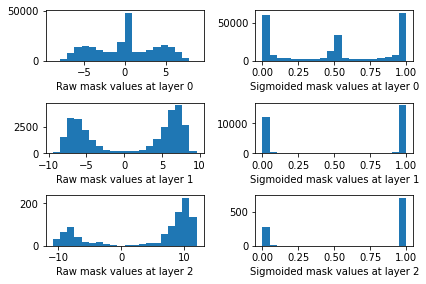

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.49377564732348866
Min: -8.79906177520752, Max: 8.777606010437012

Shape: (300, 100)
Average fraction masked: 0.4387572350564827
Min: -9.106077194213867, Max: 9.39047622680664

Shape: (100, 10)
Average fraction masked: 0.2701722657263711
Min: -11.514673233032227, Max: 11.890459060668945

Total average fraction masked: 0.48673524255411493


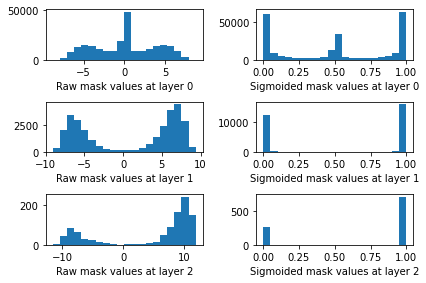

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.4947505609114091
Min: -8.63525676727295, Max: 8.78791332244873

Shape: (300, 100)
Average fraction masked: 0.445423152955311
Min: -9.14242935180664, Max: 9.405923843383789

Shape: (100, 10)
Average fraction masked: 0.2712245623994629
Min: -10.712346076965332, Max: 11.890719413757324

Total average fraction masked: 0.48835180720293836


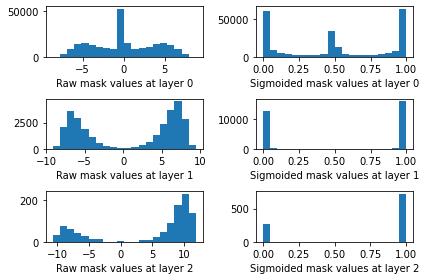

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.4954210737768062
Min: -9.154684066772461, Max: 8.8885498046875

Shape: (300, 100)
Average fraction masked: 0.44294386145563036
Min: -9.34191608428955, Max: 9.41357135772705

Shape: (100, 10)
Average fraction masked: 0.2607077165066547
Min: -10.82752513885498, Max: 12.085275650024414

Total average fraction masked: 0.4886253197313313


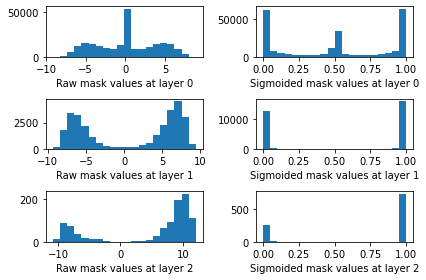

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.4923796902370864
Min: -9.009828567504883, Max: 8.76710319519043

Shape: (300, 100)
Average fraction masked: 0.44213113848778895
Min: -9.375802040100098, Max: 9.398818016052246

Shape: (100, 10)
Average fraction masked: 0.30031300841094366
Min: -10.73093318939209, Max: 12.092970848083496

Total average fraction masked: 0.4859953054350389


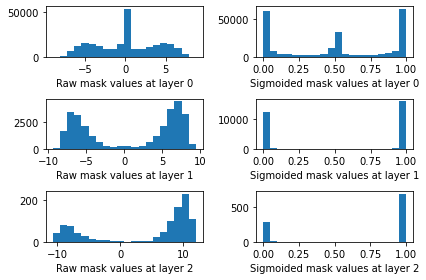

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.49346783716346987
Min: -8.721031188964844, Max: 8.959908485412598

Shape: (300, 100)
Average fraction masked: 0.4388893636481721
Min: -9.227861404418945, Max: 9.400235176086426

Shape: (100, 10)
Average fraction masked: 0.2735988413933853
Min: -10.69752025604248, Max: 11.974520683288574

Total average fraction masked: 0.48649104076516403


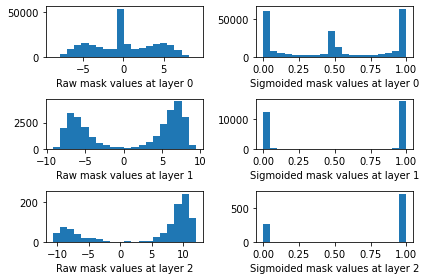

Number of weight copies: 6
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.49410051468580796
Min: -8.559091567993164, Max: 8.712869644165039

Shape: (300, 100)
Average fraction masked: 0.44136655289678917
Min: -9.153130531311035, Max: 9.33031177520752

Shape: (100, 10)
Average fraction masked: 0.2648837779309937
Min: -10.517205238342285, Max: 11.761845588684082

Total average fraction masked: 0.48729647415077637


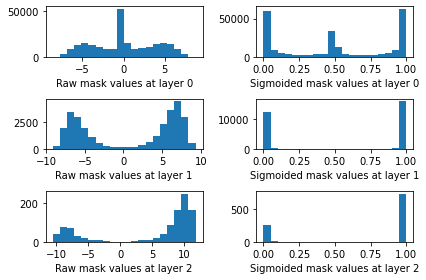

In [226]:
seed_infos = []

for seed in range(1, 11):
    seed_info = run_analysis_on_seed(seed, meta_args)
    seed_infos.append(seed_info)
    
df = pd.DataFrame(seed_infos)

In [220]:
df

,seed,regular_epochs,supermask_epochs,experiment_name,has_supermask,has_lth,test_accuracy
0,1,0,500,control_3,1,0,0.9483
1,2,0,500,control_3,1,0,0.9507
2,3,0,500,control_3,1,0,0.9497
3,4,0,500,control_3,1,0,0.9494
4,5,0,500,control_3,1,0,0.9502
5,6,0,500,control_3,1,0,0.9498
6,7,0,500,control_3,1,0,0.9470
7,8,0,500,control_3,1,0,0.9472
8,9,0,500,control_3,1,0,0.9480
9,10,0,500,control_3,1,0,0.9496


In [231]:
df.to_csv('results/iter_lot_fc_orig/results_summary_{}.csv'.format(meta_args.experiment_name))

# Analyzing the percentile-based pruning mask

This code looks at the mask you get when you filter the weights by percentile for the purpose of lottery-ticket hypothesis system pruning and retraining.

You should NOT run this with the supermask models

In [196]:
args.method = 'large_final_same_sign'
args.prev_weights = args.init_weights_h5
args.output_dir = args.init_weights_h5
assert('weights' not in args.output_dir)
args.prune_base = "0.8,0.9"
args.prune_power = 1
args.layer_cutoff = "4,6"
args.seed = args.tf_seed
args.final_weight_interpolation = 1
args.final_weights_ind = -1

In [197]:
args.init_weights_h5

'./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1'

In [198]:
preproc_cmd = (
    'python get_weight_init.py --method ' + args.method +
    ' --weights_h5 ' + args.prev_weights + '/weights' +
    ' --output_h5 ' + args.output_dir + '/init_weights' +
    ' --prune_base ' + args.prune_base +
    ' --prune_power ' + str(args.prune_power) +
    ' --layer_cutoff ' + args.layer_cutoff + 
    ' --seed ' + str(args.seed) +
    ' --final_weight_interpolation ' + str(args.final_weight_interpolation) +
    ' --final_weights_ind ' + str(args.final_weights_ind))
# os.system(preproc_cmd)
preproc_cmd

'python get_weight_init.py --method large_final_same_sign --weights_h5 ./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1/weights --output_h5 ./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1/init_weights --prune_base 0.8,0.9 --prune_power 1 --layer_cutoff 4,6 --seed 1 --final_weight_interpolation 1 --final_weights_ind -1'

In [200]:
import subprocess
proc_out = subprocess.run(preproc_cmd.split(), capture_output=True)

In [201]:
print(proc_out.stdout.decode('utf-8'))
print(proc_out.stderr.decode('utf-8'))

==prune percentiles are: 
[19.999999999999996, 0, 19.999999999999996, 0, 9.999999999999998, 0]
==no mask exists - generating first mask

2021-06-01 02:27:18.675506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
get_weight_init.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prune_num = np.int(np.sum(cur_mask) * percentile / 100)



In [202]:
if not args.init_weights_h5.endswith('/init_weights'):
    preproc_h5file = os.path.join(args.init_weights_h5, 'init_weights')
else:
    preproc_h5file = args.init_weights_h5
preproc_hf_weights = h5py.File(preproc_h5file, 'r')

In [203]:
mask_flat = np.array(preproc_hf_weights.get('mask_values'))
print(mask_flat.shape)
print(init_weights_flat.shape)

(532810,)
(532810,)


In [124]:
mask_values = split_and_shape(mask_flat, shapes)

In [204]:
if len(mask_values) == 9:
    raise Exception("this code should NOT be used with supermask")

Exception: this code should NOT be used with supermask

In [185]:
print("Basic info")
all_mask_weights = []
for mask_layer in mask_values:
    print("Shape:", mask_layer.shape)
    print("Average fraction masked:", 1 - mask_layer.mean())
    print("Min: {}, Max: {}\n".format(
        mask_layer.min(), mask_layer.max()))
    all_mask_weights.append(mask_layer.flatten())
all_mask_weights = np.concatenate(all_mask_weights)
print("Total average fraction masked:", 1-all_mask_weights.mean())

Basic info
Shape: (784, 300)
Average fraction masked: 0.19999574829931976
Min: 0.0, Max: 1.0

Shape: (300,)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Shape: (784, 300)
Average fraction masked: 0.19999574829931976
Min: 0.0, Max: 1.0

Shape: (300, 100)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Shape: (100,)
Average fraction masked: 0.08999999999999997
Min: 0.0, Max: 1.0

Shape: (300, 100)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Total average fraction masked: 0.1772550866616428
